# Subwavelength polarizing diffraction gratings studying unit cell

In this notebook I am going to test the optimal sinusoidal structures using a super cell. The stokes vector for a single
sinusoidal cell is (-0.53 , -0.117,  0.84)

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
import copy

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import hickle as hkl
from pprint import  pprint
np.set_printoptions(precision=3)
sp.set_printoptions(precision=3)

In [5]:
from py_lipss.old.pyS4 import simS4, nanoxz
from py_lipss.old.utils import plotters
from py_lipss.old.utils import numpyhacks
from py_lipss.old.utils import materials as pymaterials

In [27]:
from py_lipss.old.polarization_parameters import polarization_reflection_experiment
from py_lipss.old.computation import compute_3_structures
from py_lipss.old.utils_drawing import plot_Jones_ellipses_in_out

ImportError: cannot import name plot_input_output_3d

In [7]:
import matplotlib.mlab as mlab

In [8]:
from scipy.stats import norm

## One unit cell

In [9]:
# Defining parameters
um = 1.
mm = 1e3
nm = 1e-3
N_LATTICES = 1
a_0 = 0.580 * um #[\mu m] lattice parameter in microns 
a = a_0 *  N_LATTICES
#H = 0.3427 * mu  #[\mu m] Thickness of the grating
#w = 5. #[\mu m] width of the prism
wavelength = 0.85 * um  #[\mu m] incident wavelength

G = 11 # 51 Truncation in k-space
NP = 100  # resolution of the fields
NL =  21 # Even number for perfect alignment
NP_HIST = 10000
H = 0.21 * um
Hi = H/NL

options = {"PolarizationDecomposition": False, "Verbosity": 0}

In [10]:
 #########################################################
eV_work = pymaterials.eV2nm / wavelength * nm
epssteel = pymaterials.load_material('steel',eV_work, folder='../../.././exp_data/')
epssio2 = pymaterials.load_material('steel',eV_work, folder='../../.././exp_data/')
materials = {"Vacuum": 1.0, "Steel": epssteel, "SiO2":epssio2}

In [11]:
eV_work

1.4586376164283197

In [12]:
layers =  [{"Name":"l0", "Thickness":0, "Material":"Vacuum"}]
for iii in range(1,NL+1):
    layers.append({"Name":"l{}".format(iii), "Thickness":Hi, "Material":"Vacuum"})
    
layers.append({"Name":"l{}".format(iii+1), "Thickness":0., "Material":"Steel"})


/home/luismiguel/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


Text(0,0.5,'y ($\\mu$m)')

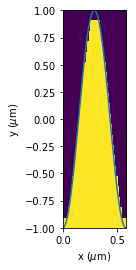

In [13]:
x0 = np.linspace(0, a, 1e5)
z0 = np.sin(2*x0*np.pi/ a_0 - np.pi/2.) # + np.random.random(50)

inner = numpyhacks.LUT_xzfun(x0, z0, NL)
mater_lut_inner = {"Vacuum":0, "Steel":1}
layers_pat = range(1,NL+1)

plt.figure()
plt.imshow(inner, extent=[x0.min(),x0.max(),z0.min(),z0.max()])
plt.plot(x0,z0)
plt.xlabel('x ($\mu$m)')
plt.ylabel('y ($\mu$m)')

In [14]:
# Define the structure using py_lipss
grating = nanoxz.NanoArray2D(a, G=G, options=options)
grating.set_materials(materials=materials)
grating.set_layers(layers)

grating.add_pattern(inner, range(1,NL+1), mater_lut_inner)
grating.set_excite(wavelength)
#orders_list = grating.orders_list

talbot_length = a**2 / wavelength
#z = np.linspace(-0.1*(talbot_length), 0.1*(talbot_length)+ H, NP)
z = np.linspace(-2., H + 2., NP)
x = np.linspace(-a / 2, a / 2., NP)

grating.get_fluxes()
#grating.get_amps()
grating.get_fields(x=x, y=[0], z=z)
grating.get_epsilon(x=x, y=[0], z=z)
grating.a = grating._a
grating.z = z

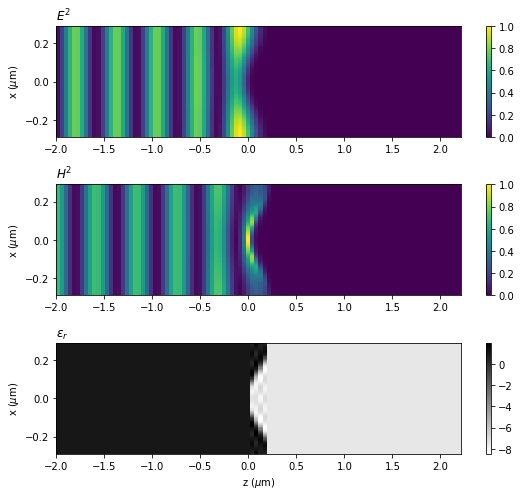

In [15]:
fg = plotters.plot2D_E2H2Eps(grating)



In [16]:
#TEMPORAL FIX
grating.sim_info.add('patterns')

In [18]:
# Setting the nanostructure to test
grating.sim_info
grt = copy.copy(grating)
grt.stop(clear_results=True)
grt.source['pAmplitude'] = 1. / np.sqrt(2)
grt.source['sAmplitude'] = 1. / np.sqrt(2.)
grt.get_fields(0, 0, z=sp.linspace(-100 * wavelength,-201 *wavelength, NP_HIST))
grt.get_fluxes()
grt.start(run_calcs=True)

In [19]:
grt, grt0, grt00 = compute_3_structures(grt)

In [20]:
grt.fluxes.sum(axis=1)[0,1]

(-0.33550281847612506+0j)

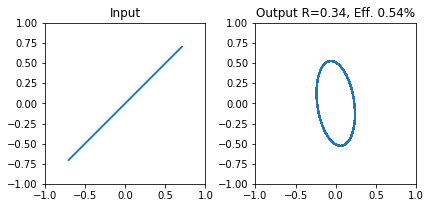

In [24]:
fg = plot_Jones_ellipses_in_out(grt, grt00, grt0)

In [75]:
z=sp.linspace(-100 * wavelength,-200 *wavelength, NP_HIST)
fg = plot_input_output_3d(grt, grt00, grt0,z,      
                                   alpha=0.4, 
                                   figargs=dict(figsize=(5,3), dpi=72),
                                  color='red')
fg.savefig('3D_polz_perfect.svg')

TypeError: polarization_reflection_experiment() takes at most 3 arguments (7 given)

In [76]:
stok, R, eta = polarization_reflection_experiment(grt, 
                                                  z=sp.linspace(-100 * wavelength,-201 *wavelength, NP_HIST))

(10000,)
-0.6303718574135542 0.17438853484161487
(10000,)
0.2746058461594779 0.22507488293724007
(10000,)
0.6458701463558956 0.17030748858702477


/home/luismiguel/.local/lib/python2.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  if __name__ == '__main__':


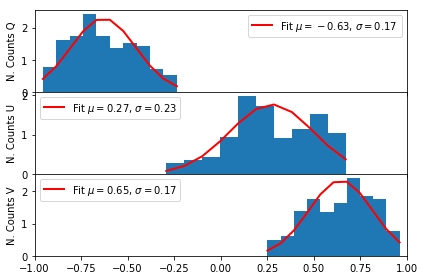

In [77]:
fg, axes = plt.subplots(nrows=3,ncols=1, sharex=True)
stokes_names = ['Q', 'U', 'V']
for _ in range(stok.shape[1]-1):
    stk = stok[:,_ +1]
    print stk.shape
    (mu, sigma) = norm.fit(stk)
    weights = sp.ones_like(stk)/float(len(stk))
    n, bins, patches = axes[_].hist(stk, 10, weights=weights, normed=1)
    y = mlab.normpdf(bins, mu, sigma)
    print mu, sigma
    axes[_].plot(bins, y, 'r', linewidth=2, label='Fit $\mu={:.2f}$, $\sigma={:.2f}$'.format(mu, sigma)) 
    axes[_].set_ylabel("N. Counts {}".format(stokes_names[_]))
    axes[_].set_xlim(-1.,1)
    axes[_].legend(loc=0)
    #axes[_].s
    
fg.tight_layout() 
fg.subplots_adjust(hspace=0)


## Perfect Supercell structure 

In [39]:
# Defining parameters
um = 1.
mm = 1e3
nm = 1e-3
N_LATTICES = 5
a_0 = 0.580 * um #[\mu m] lattice parameter in microns 
a = a_0 *  N_LATTICES
#H = 0.3427 * mu  #[\mu m] Thickness of the grating
#w = 5. #[\mu m] width of the prism
wavelength = 0.85 * um  #[\mu m] incident wavelength

G = 11 # 51 Truncation in k-space
NP = 100  # resolution of the fields
NL =  21 # Even number for perfect alignment
NP_HIST = 10000
H = 0.21 * um
Hi = H/NL

options = {"PolarizationDecomposition": False, "Verbosity": 0}

In [40]:
 #########################################################
eV_work = pymaterials.eV2nm / wavelength * nm
epssteel = pymaterials.load_material('steel',eV_work, folder='../../.././exp_data/')
epssio2 = pymaterials.load_material('steel',eV_work, folder='../../.././exp_data/')
materials = {"Vacuum": 1.0, "Steel": epssteel, "SiO2":epssio2}

In [41]:
eV_work

1.4586376164283197

In [42]:
layers =  [{"Name":"l0", "Thickness":0, "Material":"Vacuum"}]
for iii in range(1,NL+1):
    layers.append({"Name":"l{}".format(iii), "Thickness":Hi, "Material":"Vacuum"})
    
layers.append({"Name":"l{}".format(iii+1), "Thickness":0., "Material":"Steel"})


/home/luismiguel/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


Text(0,0.5,'y ($\\mu$m)')

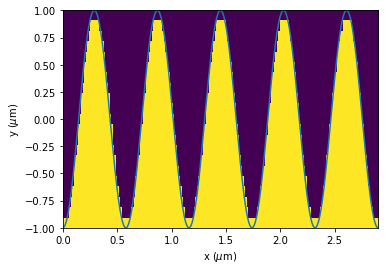

In [43]:
x0 = np.linspace(0, a, 1e5)
z0 = np.sin(2*x0*np.pi/ a_0 - np.pi/2.) # + np.random.random(50)
#z0 = x0 **2

inner = numpyhacks.LUT_xzfun(x0, z0, NL)
mater_lut_inner = {"Vacuum":0, "Steel":1}
layers_pat = range(1,NL+1)

plt.figure()
plt.imshow(inner, extent=[x0.min(),x0.max(),z0.min(),z0.max()])
plt.plot(x0,z0)
plt.xlabel('x ($\mu$m)')
plt.ylabel('y ($\mu$m)')

In [44]:
# Define the structure using py_lipss
grating = nanoxz.NanoArray2D(a, G=G, options=options)
grating.set_materials(materials=materials)
grating.set_layers(layers)

grating.add_pattern(inner, range(1,NL+1), mater_lut_inner)
grating.set_excite(wavelength)
#orders_list = grating.orders_list

talbot_length = a**2 / wavelength
#z = np.linspace(-0.1*(talbot_length), 0.1*(talbot_length)+ H, NP)
z = np.linspace(-2., H + 2., NP)
x = np.linspace(-a / 2, a / 2., NP)

grating.get_fluxes()
#grating.get_amps()
grating.get_fields(x=x, y=[0], z=z)
grating.get_epsilon(x=x, y=[0], z=z)
grating.a = grating._a
grating.z = z

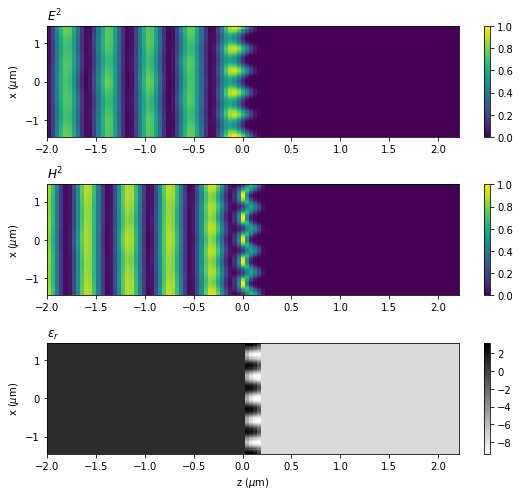

In [45]:
fg = plotters.plot2D_E2H2Eps(grating)



In [46]:
#TEMPORAL FIX
grating.sim_info.add('patterns')

In [49]:
# Setting the nanostructure to test
grating.sim_info
grt = copy.copy(grating)
grt.stop(clear_results=True)
grt.source['pAmplitude'] = 1. / np.sqrt(2)
grt.source['sAmplitude'] = 1. / np.sqrt(2.)
grt.get_fields(0, 0, z=sp.linspace(-100 * wavelength,-201 *wavelength, NP_HIST))
grt.get_fluxes()
grt.start(run_calcs=True)

In [50]:
grt, grt0, grt00 = compute_3_structures(grt)

In [51]:
grt.fluxes.sum(axis=1)[0,1]

(-0.28307686795525916+0j)

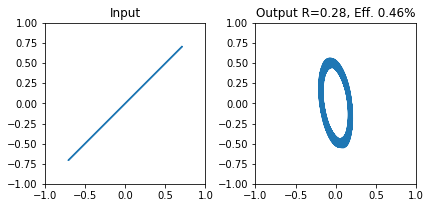

In [53]:
fg = plot_Jones_ellipses_in_out(grt, grt00, grt0)

In [55]:
fg = plotters.plot_input_output_projection(grt, grt00, grt0, alpha_top=0.01, alpha_min=0.01, marker='.')

AttributeError: 'module' object has no attribute 'plot_input_output_projection'

0.621980077995


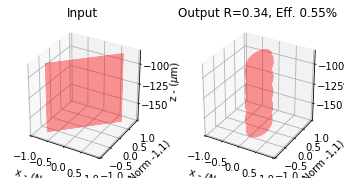

In [40]:
z=sp.linspace(-100 * l,-200 *l, NP_HIST)
fg = plotters.plot_input_output_3d(grt, grt00, grt0,z,      
                                   alpha=0.4, 
                                   figargs=dict(figsize=(5,3), dpi=72),
                                  color='red')
fg.savefig('3D_supercell_perfect.svg')

In [57]:
stok, R, eta = polarization_reflection_experiment(grt, 
                                                  z=sp.linspace(-100 * wavelength,-201 *wavelength, NP_HIST))

### Stokes parameters statistics

(10000,)
-0.7501245252209164 0.04658284316317476
(10000,)
-0.2180342682481178 0.06958778387154813
(10000,)
0.6161801711894599 0.055532244896204


/home/luismiguel/.local/lib/python2.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  if sys.path[0] == '':


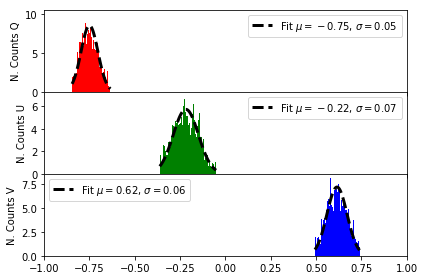

In [58]:
fg, axes = plt.subplots(nrows=3,ncols=1, sharex=True)
facecolors = ['red', 'green', 'blue']
stokes_names = ['Q', 'U', 'V']
for _ in range(stok.shape[1]-1):
    stk = stok[:,_ +1]
    print stk.shape
    (mu, sigma) = norm.fit(stk)
    weights = sp.ones_like(stk)/float(len(stk))
    n, bins, patches = axes[_].hist(stk, 100,  normed=1,
                                    facecolor=facecolors[_],
                                    histtype='stepfilled')
    y = mlab.normpdf(bins, mu, sigma)
    print mu, sigma
    axes[_].plot(bins, y, 'k--', linewidth=3, 
                 label='Fit $\mu={:.2f}$, $\sigma={:.2f}$'.format(mu, sigma),
                 ) 
    axes[_].set_ylabel("N. Counts {}".format(stokes_names[_]))
    axes[_].set_xlim(-1.,1)
    axes[_].legend(loc=0)
    #axes[_].s
    
fg.tight_layout() 
fg.subplots_adjust(hspace=0)


##  Supercell structure with defects 

In [59]:
# Defining parameters
um = 1.
mm = 1e3
nm = 1e-3

N_LATTICES = 5
a_0 = 0.580 * um #[\mu m] lattice parameter in microns 
a = a_0 *  N_LATTICES
#H = 0.3427 * mu  #[\mu m] Thickness of the grating
#w = 5. #[\mu m] width of the prism
wavelength = 0.85 * um  #[\mu m] incident wavelength

G = 11  # 51 Truncation in k-space
NP = 100  # resolution of the fields
NL =  21 # Even number for perfect alignment
NP_HIST = 10000
H = 0.21 * um
Hi = H/NL

options = {"PolarizationDecomposition": False, "Verbosity": 0}

In [63]:
 #########################################################
eV_work = pymaterials.eV2nm / wavelength * nm
epssteel = pymaterials.load_material('steel',eV_work, folder='../../../exp_data/')
epssio2 = pymaterials.load_material('steel',eV_work,  folder='../../../exp_data/')
materials = {"Vacuum": 1.0, "Steel": epssteel, "SiO2":epssio2}

In [64]:
layers =  [{"Name":"l0", "Thickness":0, "Material":"Vacuum"}]
for iii in range(1,NL+1):
    layers.append({"Name":"l{}".format(iii), "Thickness":Hi, "Material":"Vacuum"})
    
layers.append({"Name":"l{}".format(iii+1), "Thickness":0., "Material":"Steel"})


/home/luismiguel/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


Text(0,0.5,'y ($\\mu$m)')

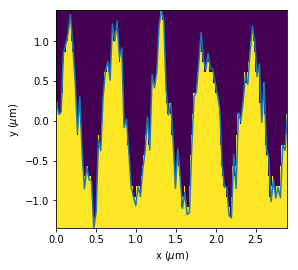

In [65]:
x0 = np.linspace(0, a, 1e2)
np.random.seed(20171118)
z0 = np.sin(2*x0*np.pi/ a_0) + 5e-1 * (2 * np.random.random(x0.shape) - 1) #50%
#z0 = x0 **2

inner = numpyhacks.LUT_xzfun(x0, z0, NL)
mater_lut_inner = {"Vacuum":0, "Steel":1}
layers_pat = range(1,NL+1)

plt.figure()
plt.imshow(inner, extent=[x0.min(),x0.max(),z0.min(),z0.max()])
plt.plot(x0,z0)
plt.xlabel('x ($\mu$m)')
plt.ylabel('y ($\mu$m)')

In [66]:
# Define the structure using py_lipss
grating = nanoxz.NanoArray2D(a, G=G, options=options)
grating.set_materials(materials=materials)
grating.set_layers(layers)

grating.add_pattern(inner, range(1,NL+1), mater_lut_inner)
grating.set_excite(wavelength)
#orders_list = grating.orders_list

talbot_length = a**2 / wavelength
#z = np.linspace(-0.1*(talbot_length), 0.1*(talbot_length)+ H, NP)
z = np.linspace(-2., H + 2., NP)
x = np.linspace(-a / 2, a / 2., NP)

grating.get_fluxes()
#grating.get_amps()
grating.get_fields(x=x, y=[0], z=z)
grating.get_epsilon(x=x, y=[0], z=z)
grating.a = grating._a
grating.z = z

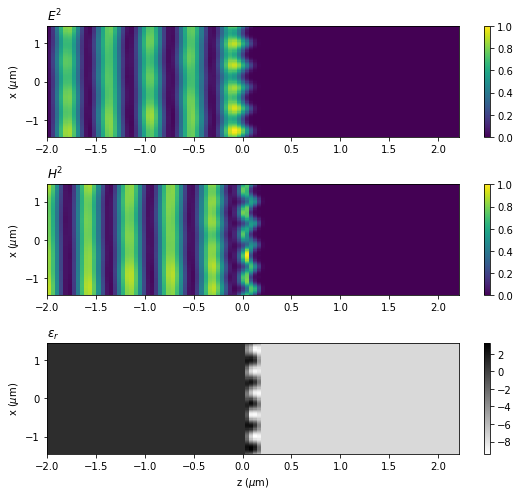

In [67]:
fg = plotters.plot2D_E2H2Eps(grating)



In [68]:
#TEMPORAL FIX
grating.sim_info.add('patterns')

In [71]:
# Setting the nanostructure to test
z = sp.linspace(-100 * wavelength, -201 * wavelength, NP_HIST)
grating.sim_info
grt = copy.copy(grating)
grt.stop(clear_results=True)
grt.source['pAmplitude'] = 1. / np.sqrt(2)
grt.source['sAmplitude'] = 1. / np.sqrt(2.)
grt.get_fields(0, 0, z=z)
grt.get_fluxes()
grt.start(run_calcs=True)

In [72]:
grt, grt0, grt00 = compute_3_structures(grt)

In [73]:
grt.fluxes.sum(axis=1)[0,1]

(-0.3129052748793281+0j)

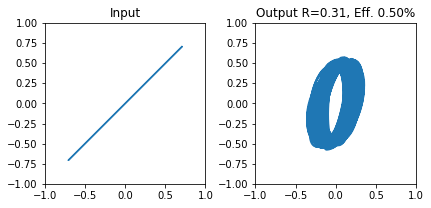

In [74]:
fg = plot_Jones_ellipses_in_out(grt, grt00, grt0)

0.621980077995


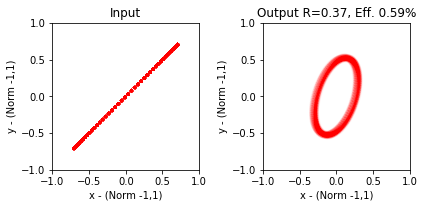

In [54]:
fg = plotters.plot_Jones_ellipses_in_out_projection(grt, grt00, grt0, alpha_top=0.01, alpha_min=0.01, marker='.')

0.621980077995


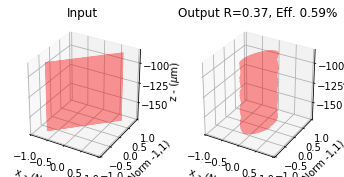

In [55]:
z=sp.linspace(-100 * l,-200 *l, NP_HIST)
fg = plotters.plot_input_output_3d(grt, grt00, grt0,z,      
                                   alpha=0.4, 
                                   figargs=dict(figsize=(5,3), dpi=72),
                                  color='red')
fg.savefig('3D_Supercell_noise.svg')

In [56]:
stok, R, eta = polarization_reflection_experiment(grt, 
                                                  z=sp.linspace(-100 * l,-201 *l, NP_HIST))

### Stokes parameters statistics

(10000,)
-0.505999914527 0.0860269058906
(10000,)
0.357110447463 0.0935755832099
(10000,)
0.772270699832 0.0622668666438


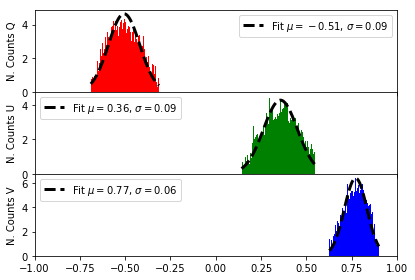

In [58]:
fg, axes = plt.subplots(nrows=3,ncols=1, sharex=True)
facecolors = ['red', 'green', 'blue']
stokes_names = ['Q', 'U', 'V']
for _ in range(stok.shape[1]-1):
    stk = stok[:,_ +1]
    print stk.shape
    (mu, sigma) = norm.fit(stk)
    weights = sp.ones_like(stk)/float(len(stk))
    n, bins, patches = axes[_].hist(stk, 100,  normed=1,
                                    facecolor=facecolors[_],
                                    histtype='stepfilled')
    y = mlab.normpdf(bins, mu, sigma)
    print mu, sigma
    axes[_].plot(bins, y, 'k--', linewidth=3, 
                 label='Fit $\mu={:.2f}$, $\sigma={:.2f}$'.format(mu, sigma),
                 ) 
    axes[_].set_ylabel("N. Counts {}".format(stokes_names[_]))
    axes[_].set_xlim(-1.,1)
    axes[_].legend(loc=0)
    #axes[_].s
    
fg.tight_layout() 
fg.subplots_adjust(hspace=0)
fg.savefig('histograms_stokes_noise.svg')

# Conclusions and further research

As we can see from the figures the modification of the polarization for the perfect cell is only that the diffracted order 
and a bit of displacement, however the supercell with defects could present some problems in the polarization for defects near equal to 
sin function.
We have used the histogram of the Stokes Parameter along a z-direction. Further testing is needed